## 0. Librerias

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

import sys
import os

!pip install pandas
import pandas as pd

!pip install nltk
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración

from collections import Counter

## 1. Carga y lectura de datos

Cargamos desde la función utils el dataset y hacemos una pequeña exploración del corpus para ver un poco la estructura del contenido, el tamaño y el balanceo de reviews.

In [2]:
from utils import load_beauty_reviews

#### El fichero de datos `All_Beauty.jsonl` no se ha commiteado pero se ha descargado en local de: https://amazon-reviews-2023.github.io/#for-user-reviews

In [17]:
# Path al directorio donde tenemos los datasets con las reviews
datasets_path = 'Inputs/data'
corpus_beauty_folder = 'All_Beauty.jsonl'

In [18]:
reviews_dict = load_beauty_reviews(datasets_path, corpus_beauty_folder)

In [5]:
print(len(reviews_dict))

701528


In [6]:
print(reviews_dict.get(180))

{'rating': 5.0, 'title': 'Amazing item.', 'text': 'Very well made,good quality and very good color.', 'images': [], 'asin': 'B073SBNLJJ', 'parent_asin': 'B073SBNLJJ', 'user_id': 'AHL5ZHN64UHJOGQLPINJ3BN4VBPA', 'timestamp': 1559566443959, 'helpful_vote': 3, 'verified_purchase': True}


#### En este ejemplo vemos que el titulo indica connotación positiva. Más adelante concatenaremos `title`y `text` para tener más contexto e informacioón para el analisis

In [7]:
# Extraer todos los ratings
ratings = [review['rating'] for review in reviews_dict.values()]

# Calcular min y max para saber escala de valoraciones
print(f"Rating mínimo: {min(ratings)}")
print(f"Rating máximo: {max(ratings)}")

Rating mínimo: 1.0
Rating máximo: 5.0


In [8]:
# Calcular porcentaje de cada valor de rating
rating_counts = Counter(ratings)
total = len(ratings)

print("Distribución de ratings:\n")
for rating in sorted(rating_counts.keys()):
    count = rating_counts[rating]
    percentage = (count / total) * 100
    print(f"Rating {rating}: {count:,} reviews ({percentage:.2f}%)")

Distribución de ratings:

Rating 1.0: 102,080 reviews (14.55%)
Rating 2.0: 43,034 reviews (6.13%)
Rating 3.0: 56,307 reviews (8.03%)
Rating 4.0: 79,381 reviews (11.32%)
Rating 5.0: 420,726 reviews (59.97%)


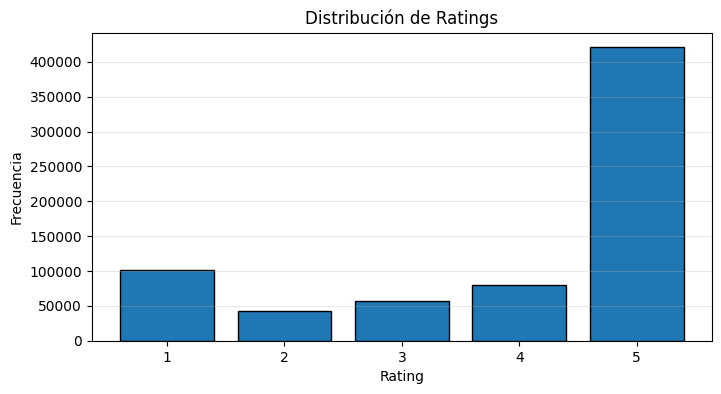

In [9]:
# Crear histograma de ratings
plt.figure(figsize=(8, 4))
plt.hist(ratings, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Ratings')
plt.xticks(range(1, 6))
plt.grid(axis='y', alpha=0.3)
plt.show()

### 1.1 Reequilibro el dataset para facilitar el estudio de la práctica

#### El corpus esta muy desbalanceado. Me quedo con un total de 6000 reviews equidistribuidas en positivo (3,4,5) y negativo (1,2). Lo hago para facilitar el entrenamiento posterior de los modelos desde el punto de vista didactico. 

In [10]:
# Filtrar 3000 reviews negativas (ratings 1,2) y 3000 positivas (ratings 3,4,5)
from collections import defaultdict
import random

# Agrupar reviews por rating
reviews_by_rating = defaultdict(list)
for idx, review in reviews_dict.items():
    rating = review['rating']
    reviews_by_rating[rating].append((idx, review))

# Separar en dos grupos: negativas y positivas (alineado con la función de etiquetado)
negative_reviews = []
positive_reviews = []

for rating in reviews_by_rating.keys():
    if rating <= 2:  # Ratings 1 y 2 → Label 1 (Negativo)
        negative_reviews.extend(reviews_by_rating[rating])
    else:  # Ratings 3, 4 y 5 → Label 0 (Positivo)
        positive_reviews.extend(reviews_by_rating[rating])

# Seleccionar aleatoriamente 3000 de cada grupo
random.shuffle(negative_reviews)
random.shuffle(positive_reviews)

selected_negative = negative_reviews[:3000]
selected_positive = positive_reviews[:3000]

# Combinar y mezclar
all_selected = selected_negative + selected_positive
random.shuffle(all_selected)

# Crear nuevo diccionario con índices consecutivos
balanced_reviews = {}
for new_idx, (old_idx, review) in enumerate(all_selected):
    balanced_reviews[new_idx] = review

# Reemplazar el diccionario original
reviews_dict = balanced_reviews
print(f"Total de reviews seleccionadas: {len(reviews_dict)}")
print(f"  - Negativas (≤2): {len(selected_negative)}")
print(f"  - Positivas (≥3): {len(selected_positive)}")

Total de reviews seleccionadas: 6000
  - Negativas (≤2): 3000
  - Positivas (≥3): 3000


Concateno `title`y `text`

In [11]:
reviews_text = []
reviews_rating = []

for review in reviews_dict.values():
    reviews_text.append(f"{review.get('title', '')} {review.get('text', '')}".strip())
    reviews_rating.append(review.get('rating'))

df = pd.DataFrame({
    'review': reviews_text,
    'rating': reviews_rating
})
df.dropna(subset=['review', 'rating'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df.head()

,review,rating
0,Sculpting Crean Use this product and find that...,5.0
1,Keep your money Foe the price one expects more...,1.0
2,Fell apart after a year Was good while it last...,1.0
3,Five Stars Works beautifully. Great for my cli...,5.0
4,Worst Product I recently purchased this produc...,1.0


### 1.2 Guardo DataFrame para uso en otros notebooks

In [14]:
# Guardar el DataFrame simplificado
import os
os.makedirs('Outputs/data', exist_ok=True)
df.to_pickle('Outputs/data/df_beauty_balanced.pkl')
print(f"DataFrame guardado: {len(df)} reviews")

DataFrame guardado: 6000 reviews


### 1.3 Convierto el corpus a minusculas y separo por palabras

In [19]:
splitted_reviews = df['review'].str.lower().str.split()

In [20]:
splitted_reviews

0       [sculpting, crean, use, this, product, and, fi...
1       [keep, your, money, foe, the, price, one, expe...
2       [fell, apart, after, a, year, was, good, while...
3       [five, stars, works, beautifully., great, for,...
4       [worst, product, i, recently, purchased, this,...
                              ...                        
5995    [vibrant, i, added, my, hair, before,, after, ...
5996    [not, my, favorite, the, hair, is, similar, to...
5997    [not, very, green, this, did, not, appear, to,...
5998    [works, well!, good, quality, but, bigger, tha...
5999                            [beautiful, love, these.]
Name: review, Length: 6000, dtype: object

In [21]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

### 1.4 Cardinalidad del vocabulario:
Cuento el número de tokens(palabras en este caso) que componen el vocabulario y cuales son los que más aparecen

In [22]:
vocabulary_ = Counter(words)
len(vocabulary_)

19122

In [23]:
vocabulary_.most_common(10)

[('the', 8806),
 ('i', 7525),
 ('and', 6086),
 ('it', 5455),
 ('to', 4830),
 ('a', 4829),
 ('this', 3345),
 ('my', 3053),
 ('is', 3013),
 ('for', 2977)]

Son palabras que no estan aportando para un análisis de sentimiento y por tanto podría eliminarlas ocn un stopwords

### 1.5 Extracción de N-grams más frecuentes:


In [24]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [25]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [26]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 599),
 (('of', 'the'), 582),
 (('in', 'the'), 489),
 (('it', 'was'), 461),
 (('this', 'is'), 461),
 (('it', 'is'), 450),
 (('i', 'was'), 406),
 (('this', 'product'), 397),
 (('and', 'i'), 384),
 (('for', 'the'), 382)]

In [27]:
trigrams_freq_.most_common(10)

[(('this', 'is', 'a'), 92),
 (('this', 'is', 'the'), 92),
 (('i', 'had', 'to'), 80),
 (('waste', 'of', 'money'), 78),
 (('i', 'love', 'this'), 77),
 (('a', 'lot', 'of'), 73),
 (('i', 'love', 'the'), 72),
 (('this', 'product', 'is'), 67),
 (('it', 'was', 'a'), 66),
 (('one', 'of', 'the'), 64)]

In [28]:
bg_freq_most_common = bigrams_freq_.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = trigrams_freq_.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [29]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

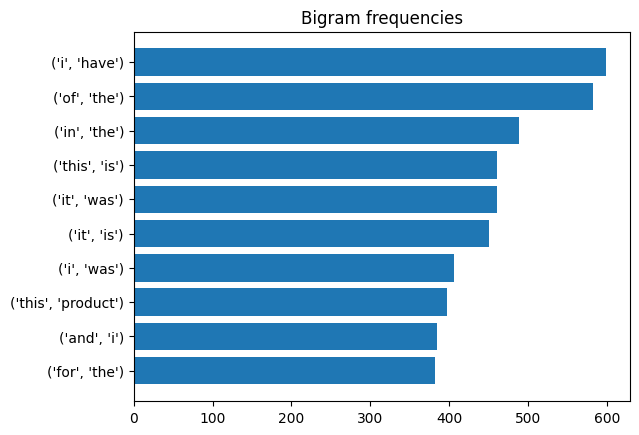

In [30]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

Los bigramas como (of the, in the, and the): Son comunes pero poco informativos para sentimiento. También incluyen pronombres que hablan de la experiencia del cliente y descriptivos (Del producto). Capturan contexto y podrían ser tenidos en cuenta en la vectorización.

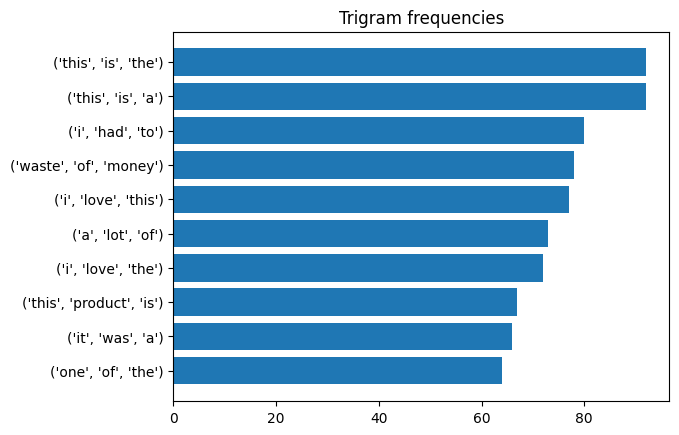

In [31]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

Vemos que para los 3-grams hay combinaciones que si son importantes, ('i', 'love', 'the'), ('i', 'love', 'this') tiene un sentimiento positivo claro. Al igual que ('waste, 'of', 'money') la tiene negativa. Capturan contexto y deberían ser tenidos en cuenta en la vectorización. 

### 1.6 Nube de palabras:


Esta visualización nos ayuda a identificar rápidamente:
- Términos más comunes en el vocabulario de belleza
- Diferencias en el lenguaje usado en reviews positivas vs negativas
- Palabras clave que caracterizan cada tipo de sentimiento

In [32]:
!pip install wordcloud
from wordcloud import WordCloud

In [33]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

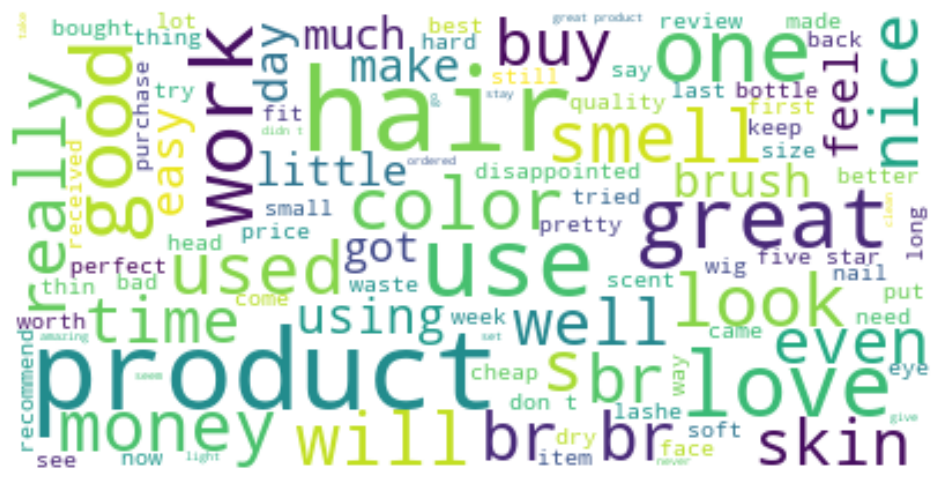

In [34]:
plot_word_cloud(words)

####
- El dataset es coherente con productos de belleza. 
- Hay bastante vocabulario emocional presente (love, great , good) en reviews positivas y, sine mbargo, más términos de experiencia de uso y descriptivos de producto para las negativas. Esto justifica mantener palabras emocionales en el preprocesado. Los bigramas serán importantes para capturar negaciones. 
- La palabra `<br, />`se repite mucho por lo que sería interesante aplicar BeautifulSoup en el preprocesado para eliminar cualquier tipo de etiqueta HTLM